In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt



E:\Anaconda2022\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
data = tf.keras.preprocessing.image_dataset_from_directory("D:\Oriental Hackathon\Tomato Diseases Detection\Datasets",
                                                          shuffle = True,
                                                          image_size=(256,256),
                                                          batch_size = 32
                                                          )

Found 16011 files belonging to 10 classes.


In [19]:
class_names = data.class_names

In [20]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [21]:
for image_batch, labels_batch in data.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 6 4 4 5 0 1 7 2 2 4 7 3 3 9 9 0 5 6 9 0 5 5 0 3 5 7 7 7 8 7 3]


visualize some images

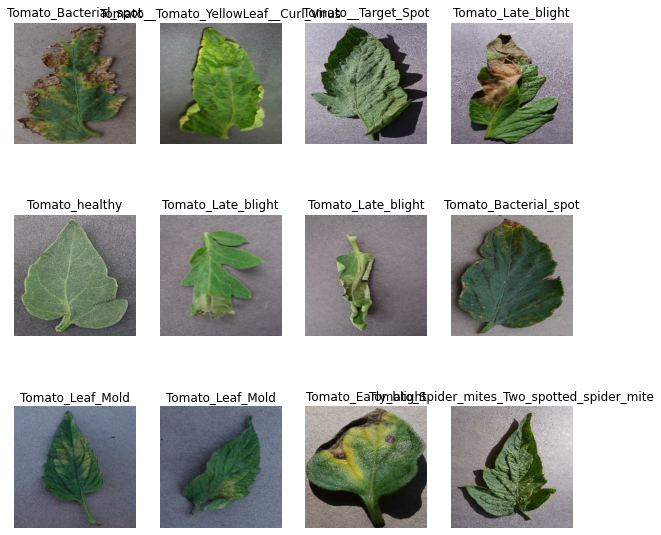

In [23]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [24]:
len(data)

501

In [25]:
train_size = 0.8
len(data)*train_size

400.8

In [26]:
train_ds = data.take(400)
len(train_ds)

400

In [28]:
test_ds = data.skip(400)
len(test_ds)

101

In [29]:
val_size=0.1
len(data)*val_size

50.1

In [30]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [31]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [32]:
def get_data_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = get_data_partitions_tf(data)

In [36]:
len(train_ds)

400

In [37]:
len(val_ds)

50

In [38]:
len(test_ds)

51

cache, shuffle and prefetch the data

In [40]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the model

creating a layer for resizing and normalization

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

DATA augmentation

In [45]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

APPLY DATA augmentation to train data


In [47]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

model architecture

In [49]:
input_shape = (32, 256, 256, 3)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
400/400 [==============================] - 473s 1s/step - loss: 1.7428 - accuracy: 0.3783 - val_loss: 1.4975 - val_accuracy: 0.4831
Epoch 2/50
400/400 [==============================] - 380s 949ms/step - loss: 1.0411 - accuracy: 0.6369 - val_loss: 1.1776 - val_accuracy: 0.5944
Epoch 3/50
400/400 [==============================] - 430s 1s/step - loss: 0.7067 - accuracy: 0.7474 - val_loss: 0.8592 - val_accuracy: 0.7281
Epoch 4/50
400/400 [==============================] - 402s 1s/step - loss: 0.5408 - accuracy: 0.8062 - val_loss: 0.6984 - val_accuracy: 0.7544
Epoch 5/50
400/400 [==============================] - 414s 1s/step - loss: 0.4717 - accuracy: 0.8328 - val_loss: 1.1387 - val_accuracy: 0.6656
Epoch 6/50
400/400 [==============================] - 408s 1s/step - loss: 0.4083 - accuracy: 0.8577 - val_loss: 0.5435 - val_accuracy: 0.8062
Epoch 7/50
400/400 [==============================] - 401s 1s/step - loss: 0.3498 - accuracy: 0.8802 - val_loss: 0.5462 - val_accuracy: 0.8

In [55]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 151s 535ms/step - loss: 0.1652 - accuracy: 0.9528


In [56]:
scores

[0.16515733301639557, 0.9528186321258545]

In [57]:
history

In [58]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [59]:
history.history['loss'][:5]

[1.7427620887756348,
 1.04114830493927,
 0.7067021727561951,
 0.5408421754837036,
 0.47170042991638184]

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

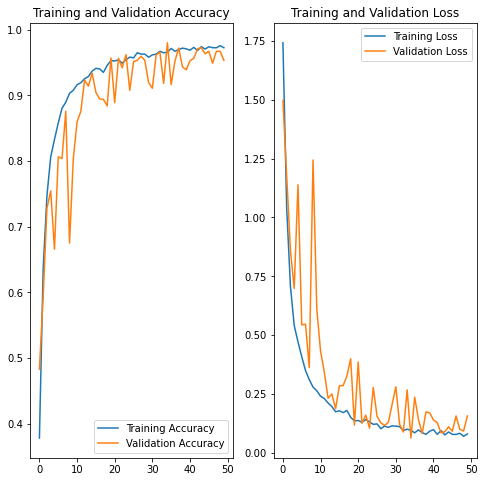

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Septoria_leaf_spot
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_Septoria_leaf_spot


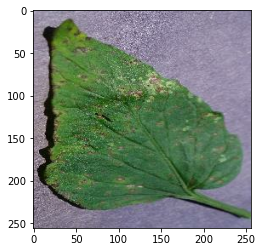

In [63]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


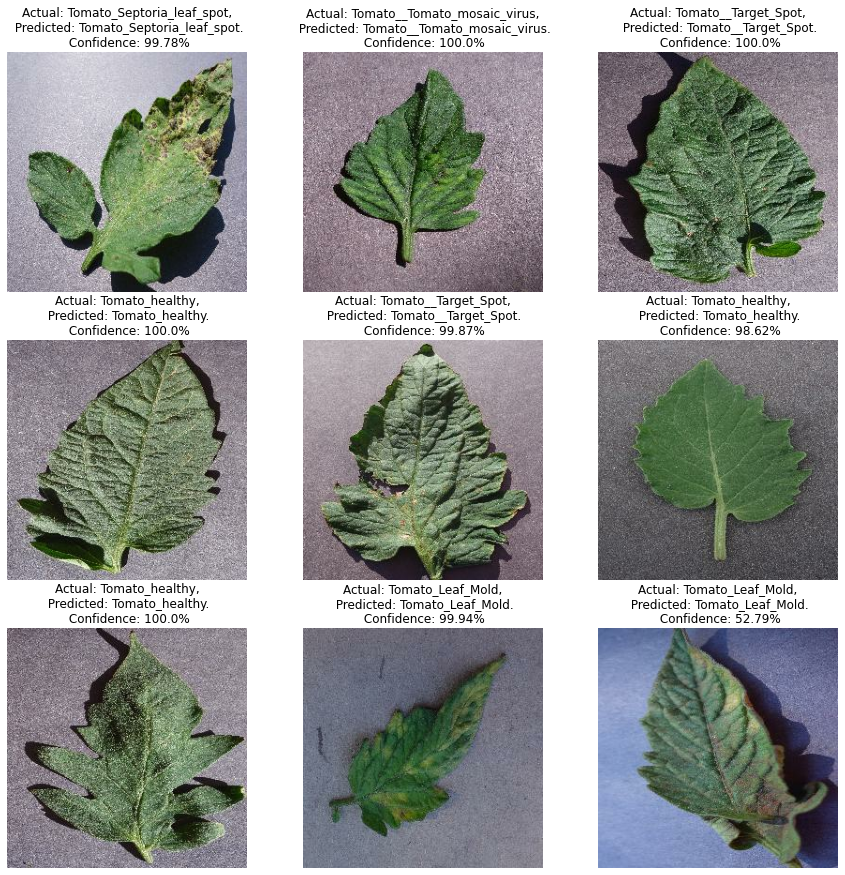

In [65]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [67]:
model.save("D:\Oriental Hackathon\Tomato Diseases Detection\Tomato.h5")

E:\Anaconda2022\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
